# **Step** 0: Setup Environment and import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pandas
!pip install seaborn

In [3]:
# import libraries
import pandas as pd
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.utils.data
from IPython import display
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

import matplotlib.image as mpimg
import numpy as np
import torchvision.models as models

from torchvision.datasets import ImageFolder
from PIL import Image

import pandas as pd
import torch.optim as optim

import sys
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display,HTML
import requests, mimetypes
from PIL import Image
import requests
from io import BytesIO
import os

import datetime as dt

# **Step** 1: Data Preprocessing
Use dataset from https://osf.io/wsnzr/?view_only=319a53cf1bf542bbbe538aba37916537 and use only the Art Category data for our prediction model. Unnecessary columns are droped while some new columns are generated. Two new csv file are generated: Cleaned Art Data.csv and One Hot Cleaned Art Data.csv. 

In [ ]:
# filter art data
df = pd.read_csv('/content/drive/MyDrive/294/Data_API.csv')
categories = df["Category"].unique()
for category in categories:
    globals()[category.lower() + "_data"] = df[df["Category"] == category]

# find art NFTs that have been sold more than once
art_data_by_id = art_data.groupby("Unique_id_collection").count()
art_data_by_id = art_data_by_id[art_data_by_id["Collection_cleaned"] > 1]
ids_sold_more_than_once = art_data_by_id.index

# Construct a new dataframe that contains past transaction info
art_data_sold_more_than_once = art_data[art_data["Unique_id_collection"].isin(ids_sold_more_than_once)]
art_data_sold_more_than_once = art_data_sold_more_than_once.sort_values(["Unique_id_collection", "Datetime_updated_seconds"], ascending = True).reset_index()
art_data_sold_more_than_once["Past_Price_USD"] = [list(art_data_sold_more_than_once["Price_USD"])[-1]] + list(art_data_sold_more_than_once["Price_USD"])[0:-1]
art_data_sold_more_than_once["Past_Datetime_updated"] = [list(art_data_sold_more_than_once["Datetime_updated"])[-1]] + list(art_data_sold_more_than_once["Datetime_updated"])[0:-1]
art_data_sold_more_than_once["Days_Since_Last_Sell"] = pd.to_datetime(art_data_sold_more_than_once['Datetime_updated']) - pd.to_datetime(art_data_sold_more_than_once['Past_Datetime_updated'])
# art_data_sold_more_than_once = art_data_sold_more_than_once[["Unique_id_collection", "Image_url_1", "Collection_cleaned", "Past_Price_USD", "Price_USD", "Datetime_updated", "Days_Since_Last_Sell"]]
art_data_sold_more_than_once = art_data_sold_more_than_once[art_data_sold_more_than_once['Unique_id_collection'].duplicated()]

# filter out invalid urls
art_data_sold_more_than_once = art_data_sold_more_than_once[art_data_sold_more_than_once['Image_url_1'].str.contains("https", na=False)]
art_data_sold_more_than_once = art_data_sold_more_than_once.dropna().sample(n = 50000, replace = False)
art_data_sold_more_than_once = art_data_sold_more_than_once.reset_index().drop(columns = ["index"])
display(art_data_sold_more_than_once)

# Save it to CSV
# art_data_sold_more_than_once.to_csv('/content/drive/MyDrive/294/Art Sample.csv', index = False) 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,4,6,8,9,10,14,15,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,level_0,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,...,Market,Datetime_updated,Datetime_updated_seconds,Permanent_link,Unique_id_collection,Collection_cleaned,Category,Past_Price_USD,Past_Datetime_updated,Days_Since_Last_Sell
0,930049,0xd07dc4262bcdbf85190c01c996b4c06a461d2430,140657,0xbf9da0d58156957ccc686a31ff4eaa1f617d947378cf...,0x8364d4b386b8643badad2e633514f431639ebd86,iartsometimes,0xef3d9ddf59f3622a04753c61e6c4d596e7fc610d,Alex3422,https://lh3.googleusercontent.com/OGlCTH1tP26S...,https://ipfs.io/ipfs/QmUoDEcLz3qmcDL8GPLKo6Wm1...,...,OpenSea,2021-02-21 00:00:00,2021-02-21 15:42:27,https://opensea.io/assets/0xd07dc4262bcdbf8519...,"('Rarible', '140657')",Rari,Art,19.004800,2021-02-18 00:00:00,3 days
1,447444,0x06012c8cf97bead5deae237070f9587f8e7a266d,1896501,0x1f751e962f132a58b6382dc9c55410d37e84ff608675...,0xf0b22f7e45a223a106c35eda11bd055a70a234dd,0xF0,0x4021c3e7cbe3f42df3d24834edaef2ca86a0b0aa,Syntc,https://lh3.googleusercontent.com/R8ieJ-H6j5lt...,https://img.cryptokitties.co/0x06012c8cf97bead...,...,OpenSea,2021-02-27 00:00:00,2021-02-27 11:40:54,https://opensea.io/assets/0x06012c8cf97bead5de...,"('Cryptokitties', '1896501')",Cryptokittie,Art,7.383450,2020-04-18 00:00:00,315 days
2,865321,0x06012c8cf97bead5deae237070f9587f8e7a266d,977750,0x9a8d11aec6d5f460ee720c01e9f22f54c67cea0cf4f1...,0xcfee1c9c3a4e8e709e2f177770febae79875c531,Zihan,0x38d31a5c839fdcf1202fbb3a1347b4fea35c694d,ccie,https://storage.opensea.io/0x06012c8cf97bead5d...,https://img.cryptokitties.co/0x06012c8cf97bead...,...,OpenSea,2018-09-25 00:00:00,2018-09-25 00:27:38,https://opensea.io/assets/0x06012c8cf97bead5de...,"('Cryptokitties', '977750')",Cryptokittie,Art,1.396750,2018-09-09 00:00:00,16 days
3,999542,0xd07dc4262bcdbf85190c01c996b4c06a461d2430,67094,0xad0bc17736bad650d9689ee8e81fb24297d0e2671ca1...,0x240ad467a71210629d71d4de22ebde27951c83fc,Collin3,0xc9c969f4b9ffae5027fdbfaf13404fcbd4def389,SATMAN,https://lh3.googleusercontent.com/GoKi-H7E2vNR...,https://ipfs.io/ipfs/QmZ8bCBJjeakutwtnkVx6QoTy...,...,OpenSea,2021-02-22 00:00:00,2021-02-22 01:43:19,https://opensea.io/assets/0xd07dc4262bcdbf8519...,"('Rarible', '67094')",Rari,Art,34.167625,2021-01-30 00:00:00,23 days
4,276437,0x06012c8cf97bead5deae237070f9587f8e7a266d,1453045,0x0593e7b4e8ae90b06af5403cfdd611c971c8a8ccd484...,0xd68c2b3086f9d0e278b0e0aea23ed361fa7c28e1,0xd68c2b3086,0x92e75270032c1ef9ba6842e8978a9c99adc2a365,foolsrushinn101,https://storage.opensea.io/0x06012c8cf97bead5d...,https://img.cryptokitties.co/0x06012c8cf97bead...,...,OpenSea,2019-03-14 00:00:00,2019-03-14 01:41:46,https://opensea.io/assets/0x06012c8cf97bead5de...,"('Cryptokitties', '1453045')",Cryptokittie,Art,3.191951,2019-03-12 00:00:00,2 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,323130,0x06012c8cf97bead5deae237070f9587f8e7a266d,1561762,0xb0754042e1e48b241a36128548ea051f73b359bf75ab...,0x16205a6048b6af17f1ac1a009bbf2ed9289e6921,stoic,0xde6dd4d790cdd2efbb0c215abe41baaca43f77f6,razzmatazzrr,https://storage.opensea.io/0x06012c8cf97bead5d...,https://img.cryptokitties.co/0x06012c8cf97bead...,...,OpenSea,2019-06-01 00:00:00,2019-06-01 23:35:25,https://opensea.io/assets/0x06012c8cf97bead5de...,"('Cryptokitties', '1561762')",Cryptokittie,Art,2.657706,2019-05-05 00:00:00,27 days
49996,317163,0x06012c8cf97bead5deae237070f9587f8e7a266d,1546146,0x95a1fca575dab3bbaf5e5d5ce18709d18e047584c277...,0xf74258dc3ed37f703ec977caff18320eff58122d,0xf74258dc3ed37f703ec977caff18320eff58122d,0x2f261a227480b7d1802433d05a92a27bab645032,The_OG_McDuff,https://lh3.googleusercontent.com/I_Q3vT_HaWXM...,https://img.cryptokitties.co/0x06012c8cf97bead...,...,OpenSea,2020-01-08 00:00:00,2020-01-08 23:49:27,https://opensea.io/assets/0x06012c8cf97bead5de...,"('Cryptokitties', '1546146')",Cryptokittie,Art,6.227213,2019-04-28 00:00:00,255 days
49997,451324,0x06012c8cf97bead5deae237070f9587f8e7a266d,1907552,0xaaa1dd6d5c347504f

In [ ]:
# create one hot 
data = pd.read_csv('/content/drive/MyDrive/294/Art Sample.csv')
data = data[["Unique_id_collection", "Image_url_1", "Collection_cleaned", "Past_Price_USD", "Price_USD", "Datetime_updated", "Days_Since_Last_Sell"]]
display(data)

def create_onehot(data, columns):
    columns = sorted(columns)
    for column in columns:
        values = data[column].unique()
        for value in values:
        # for value in values:
            data[column + "=" + str(value)] = (data[column] == value).astype(int)
        data = data.drop(column, axis = 1)
    return data
data = create_onehot(data, ["Collection_cleaned"])
data["Days_Since_Last_Sell"] = data["Days_Since_Last_Sell"].str.split(" ").str[0]
# data.to_csv('/content/drive/MyDrive/294/One Hot Sample.csv', index = False) 

,Unique_id_collection,Image_url_1,Collection_cleaned,Past_Price_USD,Price_USD,Datetime_updated,Days_Since_Last_Sell
0,"('Rarible', '140657')",https://lh3.googleusercontent.com/OGlCTH1tP26S...,Rari,19.004800,19.307500,2021-02-21 00:00:00,3 days
1,"('Cryptokitties', '1896501')",https://lh3.googleusercontent.com/R8ieJ-H6j5lt...,Cryptokittie,7.383450,7.383450,2021-02-27 00:00:00,315 days
2,"('Cryptokitties', '977750')",https://storage.opensea.io/0x06012c8cf97bead5d...,Cryptokittie,1.396750,1.396750,2018-09-25 00:00:00,16 days
3,"('Rarible', '67094')",https://lh3.googleusercontent.com/GoKi-H7E2vNR...,Rari,34.167625,67.691200,2021-02-22 00:00:00,23 days
4,"('Cryptokitties', '1453045')",https://storage.opensea.io/0x06012c8cf97bead5d...,Cryptokittie,3.191951,3.191951,2019-03-14 00:00:00,2 days
...,...,...,...,...,...,...,...
49995,"('Cryptokitties', '1561762')",https://storage.opensea.io/0x06012c8cf97bead5d...,Cryptokittie,2.657706,2.657706,2019-06-01 00:00:00,27 days
49996,"('Cryptokitties', '1546146')",https://lh3.googleusercontent.com/I_Q3vT_HaWXM...,Cryptokittie,6.227213,6.227213,2020-01-08 00:00:00,255 days
49997,"('Cryptokitties', '1907552')",https://lh3.googleusercontent.com/zltD1WRD5Bm-...,Cryptokittie,6.212419,6.212419,2020-05-01 00:00:00,1 days
49998,"('Cryptokitties', '1433369')",https://storage.opensea.io/0x06012c8cf97bead5d...,Cryptokittie,0.668997,0.668997,2019-07-11 00:00:00,91 days


In [ ]:
# helper function return boolean indicate whether or not it is a GIF
def not_GIF(url):
    r = requests.get(url)
    image_type = r.headers['Content-Type'].split("/")[-1]
    if image_type == "gif":
        return False
    else:
        return True

In [ ]:
# Visualize data: display image from the url
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')

def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'

pd.set_option('display.max_colwidth', None)
image_cols = ['Image_url_1']  #<- define which columns will be used to convert to html

# Create the dictionariy to be passed as formatters
format_dict = {}
for image_col in image_cols:
    format_dict[image_col] = path_to_image_html

display(HTML(data[:100].to_html(escape=False ,formatters=format_dict)))

,Unique_id_collection,Image_url_1,Past_Price_USD,Price_USD,Datetime_updated,Days_Since_Last_Sell,Collection_cleaned=Rari,Collection_cleaned=Cryptokittie,Collection_cleaned=Vox,Collection_cleaned=Meme,Collection_cleaned=Hashmask,Collection_cleaned=Meta,Collection_cleaned=Cryptoskull,Collection_cleaned=Superrare,Collection_cleaned=Chubbie,Collection_cleaned=Uacollaboration,Collection_cleaned=Lux,Collection_cleaned=Redlioneyegazette,Collection_cleaned=Art,Collection_cleaned=King,Collection_cleaned=Twerky,Collection_cleaned=Prank,Collection_cleaned=Ropemakersunited,Collection_cleaned=Apeinfinanceshop,Collection_cleaned=Cyber,Collection_cleaned=Wrapped,Collection_cleaned=Bastard,Collection_cleaned=Cryptocube,Collection_cleaned=Pix,Collection_cleaned=Nyancatofficial,Collection_cleaned=Real,Collection_cleaned=Bykevinabosch,Collection_cleaned=Erto,Collection_cleaned=Knownorigin,Collection_cleaned=Globephoto,Collection_cleaned=Flushlol,Collection_cleaned=Ducksong,Collection_cleaned=Color,Collection_cleaned=Mark,Collection_cleaned=Maker,Collection_cleaned=Genertivekcomposition,Collection_cleaned=Prfofbeauty,Collection_cleaned=Josie,Collection_cleaned=Inventory,Collection_cleaned=Pill,Collection_cleaned=Beeple,Collection_cleaned=Bitsforai,Collection_cleaned=Open,Collection_cleaned=Snarkart,Collection_cleaned=Cryptomorph,Collection_cleaned=Maxo,Collection_cleaned=Ethercat,Collection_cleaned=Digital,Collection_cleaned=Eulerbeat,Collection_cleaned=Joyworld,Collection_cleaned=Thorchaincollectible,Collection_cleaned=Autoglyph,Collection_cleaned=Cryptoerior,Collection_cleaned=Tory,Collection_cleaned=Hackata,Collection_cleaned=Seenhau,Collection_cleaned=Hashrune,Collection_cleaned=Pascalboyart,Collection_cleaned=Pakxtrevorjone,Collection_cleaned=Element,Collection_cleaned=Cryptoarte,Collection_cleaned=Xcopy,Collection_cleaned=Ssxlau,Collection_cleaned=Nfp,Collection_cleaned=Boi,Collection_cleaned=Mad,Collection_cleaned=Deafbeef,Collection_cleaned=Xmonsxyz,Collection_cleaned=Slimesunday,Collection_cleaned=Cryptocorgi,Collection_cleaned=Bitairt,Collection_cleaned=Titlebypak,Collection_cleaned=Royal,Collection_cleaned=Bosslogic,Collection_cleaned=Fewocio,Collection_cleaned=Satoshi,Collection_cleaned=Asyncart,Collection_cleaned=Ultra
0,"('Rarible', '140657')",,19.004800,19.307500,2021-02-21 00:00:00,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"('Cryptokitties', '1896501')",,7.383450,7.383450,2021-02-27 00:00:00,315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"('Cryptokitties', '977750')",,1.396750,1.396750,2018-09-25 00:00:00,16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"('Rarible', '67094')",,34.167625,67.691200,2021-02-22 00:00:00,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"('Cryptokitties', '1453045')",,3.191951,3.191951,2019-03-14 00:00:00,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"('Cryptokitties', '797047')",,1.376700,1.376700,2018-08-26 00:00:00,46,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,"('Cryptokitties', '1831027')",,3.318900,3.318900,2020-02-10 00:00:00,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,"('Voxodeus-minter', '0')",,247.348000,247.348000,2021-04-15 00:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
# # Save image for training
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv')
train_unique_image_ids = list(data["Unique_id_collection"].unique())
invalid_ids = []
destination = '/content/drive/MyDrive/294/Images'
for ID in train_unique_image_ids:
  try:
    url = data.loc[data.Unique_id_collection==ID].iloc[0,1]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    nft_RGB = img.convert('RGB')
    nft_RGB.save(destination+'/'+ID+'.png')
  except:
    invalid_ids.append(ID)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
path = '/content/drive/MyDrive/294/Images'
print('filenum:',len([lists for lists in os.listdir(path) if os.path.isfile(os.path.join(path, lists))]))

filenum: 36471


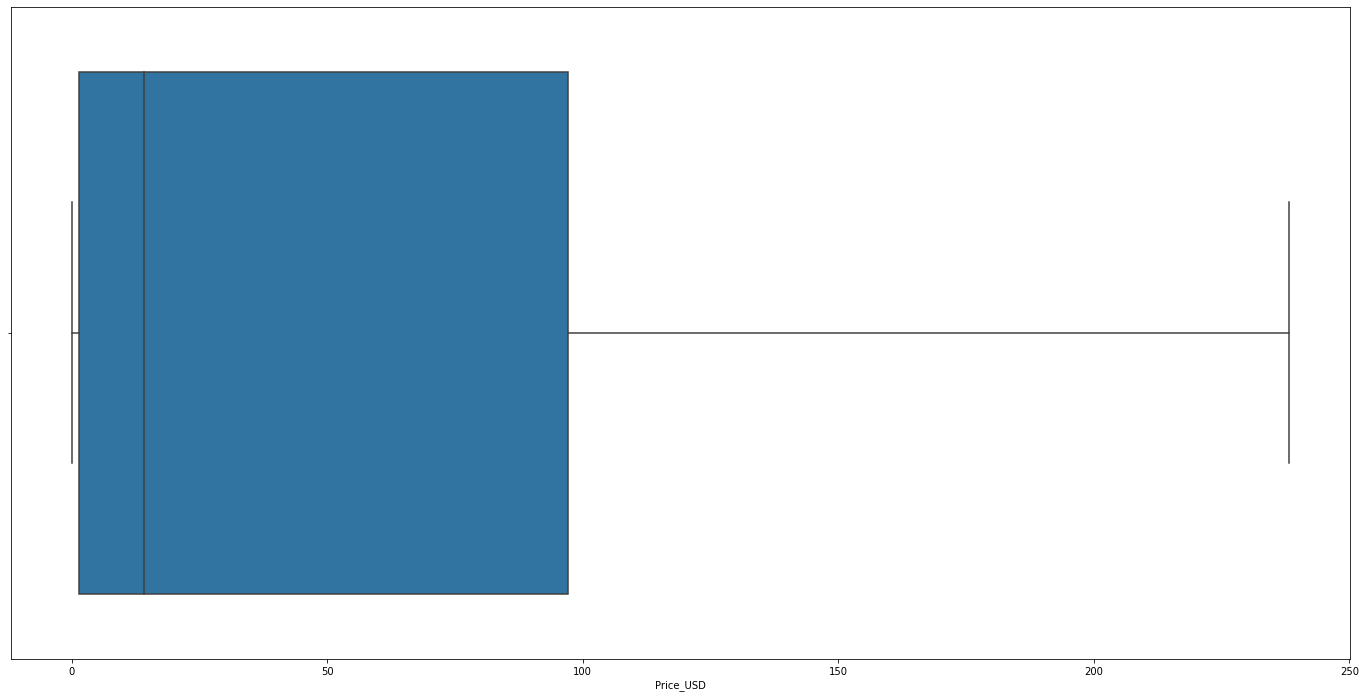

In [23]:
# Generate Sampled Art NFTs Price Distributution Plot
plt.figure(figsize=(24,12))  
df = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv').iloc[:1000]
sns.boxplot(data=df, x='Price_USD',  showfliers = False)


# **Step** 2: Model Training
These following models will be used:

1. Linear Regression
*   without image info (Training RMSE: 1767.1873182558932 Test RMSE: 3659.3980296512764)

2. Random Forest
*   without image info (Training RMSE: 1208.3319243476262 Test RMSE: 1803.2490486426666)

3. CNN: Self define CNN model that use both image and scalar input for prediction: To input the image into Alexnet. Then the scalar values are concatenated and feed to differnet models.
*   AlexNet + Linear Regression (Training RMSE: 1592.619533917731 Test RMSE: 2013.3240702391226)
*   AlexNet + Random Forest (Training RMSE: 689.3814322417326 Test RMSE: 1205.4634207866995)
*   AlexNet + DNN

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


1767.1873182558932

3659.3980296512764

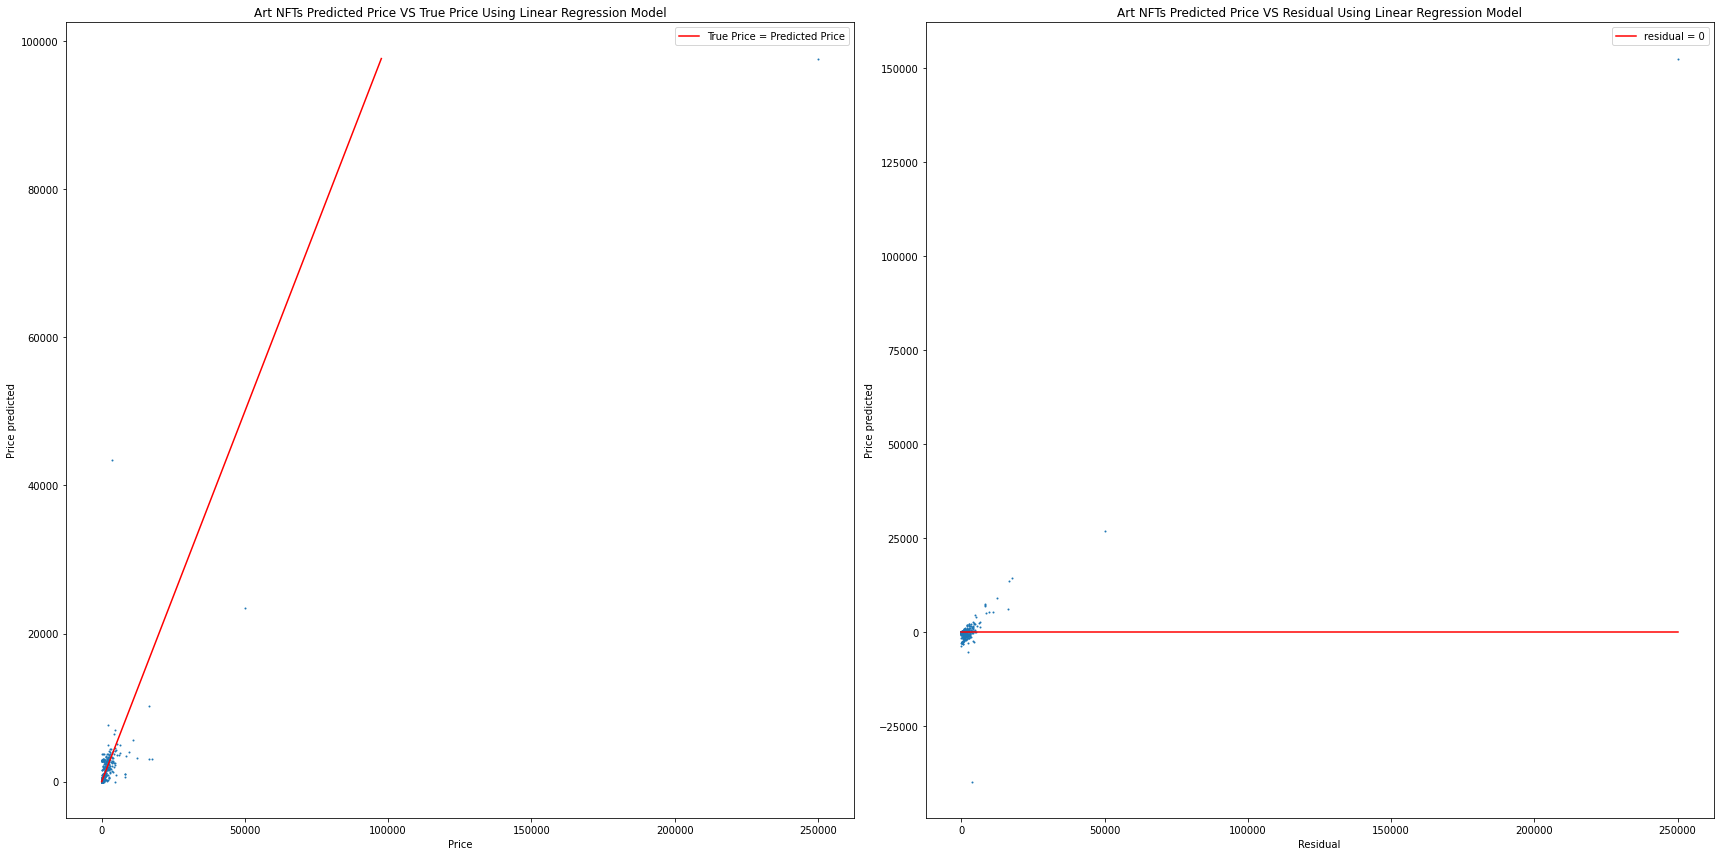

In [26]:
# 1 Linear Regression Model without image info
def rmse(a, b):
    return float(np.sqrt(((a - b) ** 2).mean()))

def ReLU(x):
  return np.maximum(x, 0, x)

data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv').iloc[:10000]
# data = data[(data['Price_USD'] >= np.percentile(data['Price_USD'], 1)) & (data['Price_USD'] <= np.percentile(data['Price_USD'], 99))]
X = data.drop(columns = ["Unique_id_collection", "Image_url_1", "Price_USD"])

# Process the date data: convert it into numerical value
X["Datetime_updated"] = pd.to_datetime(X["Datetime_updated"])
X["Datetime_updated"] = X["Datetime_updated"].map(dt.datetime.toordinal)
y = data["Price_USD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# fit the linear model and make predictions
lr = lm.LinearRegression(fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)

# ReLU after linear regression to ensure output greater than 0
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test) 
y_train_pred = ReLU(y_train_pred)
y_test_pred = ReLU(y_test_pred)

# compute RMSE on train and test sets
train_rmse_cpc = rmse(y_train_pred, y_train)
test_rmse_cpc = rmse(y_test_pred, y_test)
display(train_rmse_cpc, test_rmse_cpc)

# Visualize training outcome
plt.figure(figsize=(24,12))     

plt.subplot(121)               

x = np.linspace(np.min(y_test_pred), np.max(y_test_pred),10)
plt.scatter(x = y_test, y = y_test_pred, s = 1)
plt.plot(x, x, '-r', label = 'True Price = Predicted Price')
plt.xlabel("Price")
plt.ylabel("Price predicted")
plt.title('Art NFTs Predicted Price VS True Price Using Linear Regression Model')
plt.legend()

plt.subplot(122)     
x = np.linspace(np.min(y_test), np.max(y_test),10)
plt.scatter(x = y_test, y = y_test - y_test_pred, s = 1)
plt.plot(x, 0 * x, '-r', label = 'residual = 0')
plt.xlabel("Residual")
plt.ylabel("Price predicted")
plt.title("Art NFTs Predicted Price VS Residual Using Linear Regression Model")
plt.legend()

plt.tight_layout() 

1208.3319243476262

1803.2490486426666

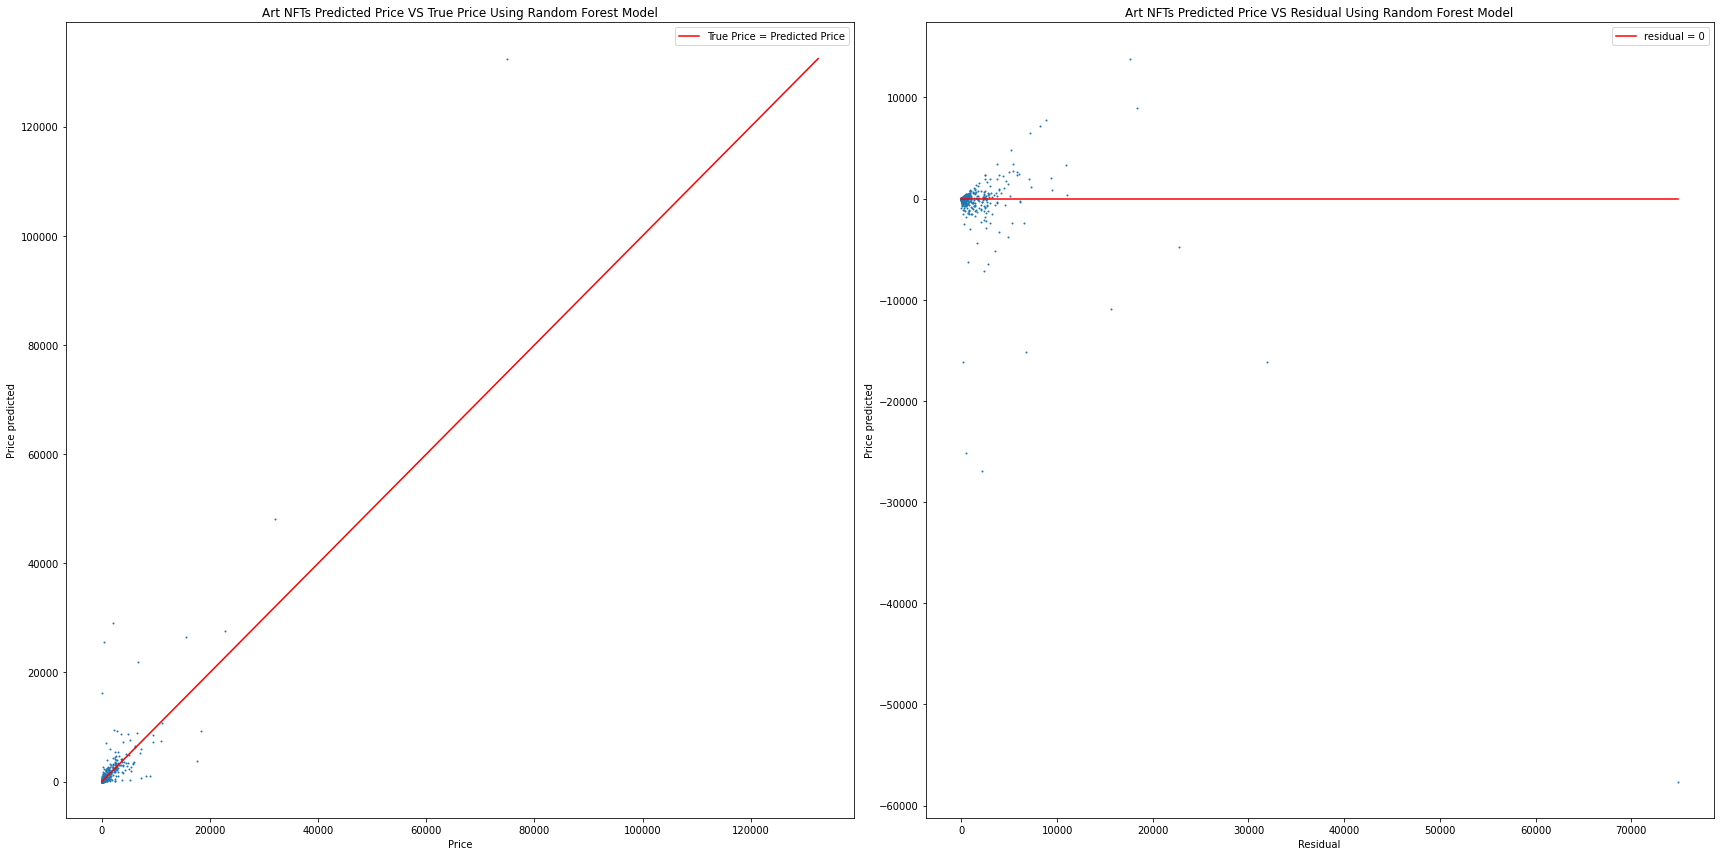

In [27]:
# 2 Random Forest without image info
def rmse(a, b):
    return float(np.sqrt(((a - b) ** 2).mean()))

def ReLU(x):
  return np.maximum(x, 0, x)

# Fitting Random Forest Regression to the dataset
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv').iloc[:10000]
# data = data[(data['Price_USD'] >= np.percentile(data['Price_USD'], 1)) & (data['Price_USD'] <= np.percentile(data['Price_USD'], 99))]

X = data.drop(columns = ["Unique_id_collection", "Image_url_1", "Price_USD"])

# Process the date data: convert it into numerical value
X["Datetime_updated"] = pd.to_datetime(X["Datetime_updated"])
X["Datetime_updated"] = X["Datetime_updated"].map(dt.datetime.toordinal)
y = data["Price_USD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

 # create regressor object
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# predict
y_test_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
y_train_pred = ReLU(y_train_pred)
y_test_pred = ReLU(y_test_pred)

# compute RMSE on train and test sets
train_rmse_cpc = rmse(y_train_pred, y_train)
test_rmse_cpc = rmse(y_test_pred, y_test)
display(train_rmse_cpc, test_rmse_cpc)

# Visualizations
plt.figure(figsize=(24,12))  

plt.subplot(121)               
x = np.linspace(np.min(y_test_pred), np.max(y_test_pred),10)
plt.scatter(x = y_test, y = y_test_pred, s = 1)
plt.plot(x, x, '-r', label = 'True Price = Predicted Price')
plt.xlabel("Price")
plt.ylabel("Price predicted")
plt.title('Art NFTs Predicted Price VS True Price Using Random Forest Model')
plt.legend()

plt.subplot(122)     
x = np.linspace(np.min(y_test), np.max(y_test),10)
plt.scatter(x = y_test, y = y_test - y_test_pred, s = 1)
plt.plot(x, 0 * x, '-r', label = 'residual = 0')
plt.xlabel("Residual")
plt.ylabel("Price predicted")
plt.title("Art NFTs Predicted Price VS Residual Using Random Forest Model")
plt.legend()

plt.tight_layout() 

In [22]:
class MyDataset(Dataset):
    def __init__(self, filenames, transform):
        self.filenames = filenames
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
 
    # try except must included to handle the case where some images are not available (size too big!)
    def __getitem__(self, idx):
        try:
          image = Image.open(self.filenames[idx]).convert('RGB')
          image = self.transform(image)
        except:
          image = np.nan
        return image

In [ ]:
# 3 AlexNet 

# Load Data choose data segment
destination = '/content/drive/MyDrive/294/Images/'
data = pd.read_csv('/content/drive/MyDrive/294/One Hot Sample.csv').iloc[:10000]

# Convert datetime to number
data["Datetime_updated"] = pd.to_datetime(data["Datetime_updated"])
data["Datetime_updated"] = data["Datetime_updated"].map(dt.datetime.toordinal)

# Add new column to indicate the path to NFTs
data["Image_path"] = destination + data["Unique_id_collection"] + '.png'

# Define the number of classifiers after the Alexnet
NUM_OF_CLASS = 10

# Define transformer
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

# Setup dataloader
image_inputs = list(data["Image_path"])
image_dataset = MyDataset(image_inputs, transformer)
dataloader = DataLoader(image_dataset, shuffle = False)

# Define device
device = torch.device("cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup Alexnet
alexnet = models.alexnet(pretrained = False)
alexnet.to(device)
alexnet.classifier[6] = nn.Linear(4096, NUM_OF_CLASS)

# Pass each image in to the alexnet
Image_info = []
for i, (image) in enumerate(dataloader):
  try:
    output_tensor = alexnet(image)
    output_arr = output_tensor.detach().flatten().tolist()
    Image_info.append(output_arr)
  except:
    Image_info.append([np.nan] * NUM_OF_CLASS)

# Transpose the list in oreder to add them as columns to dataframe
Image_info = np.array(Image_info).T.tolist()

# Upadate dataframe
for i in range(NUM_OF_CLASS):
  data["Image_class_" + str(i)] = Image_info[i]
  
# display(data)
# data.to_csv('/content/drive/MyDrive/294/AlexNet Data.csv', index = False) 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


1592.619533917731

2013.3240702391226

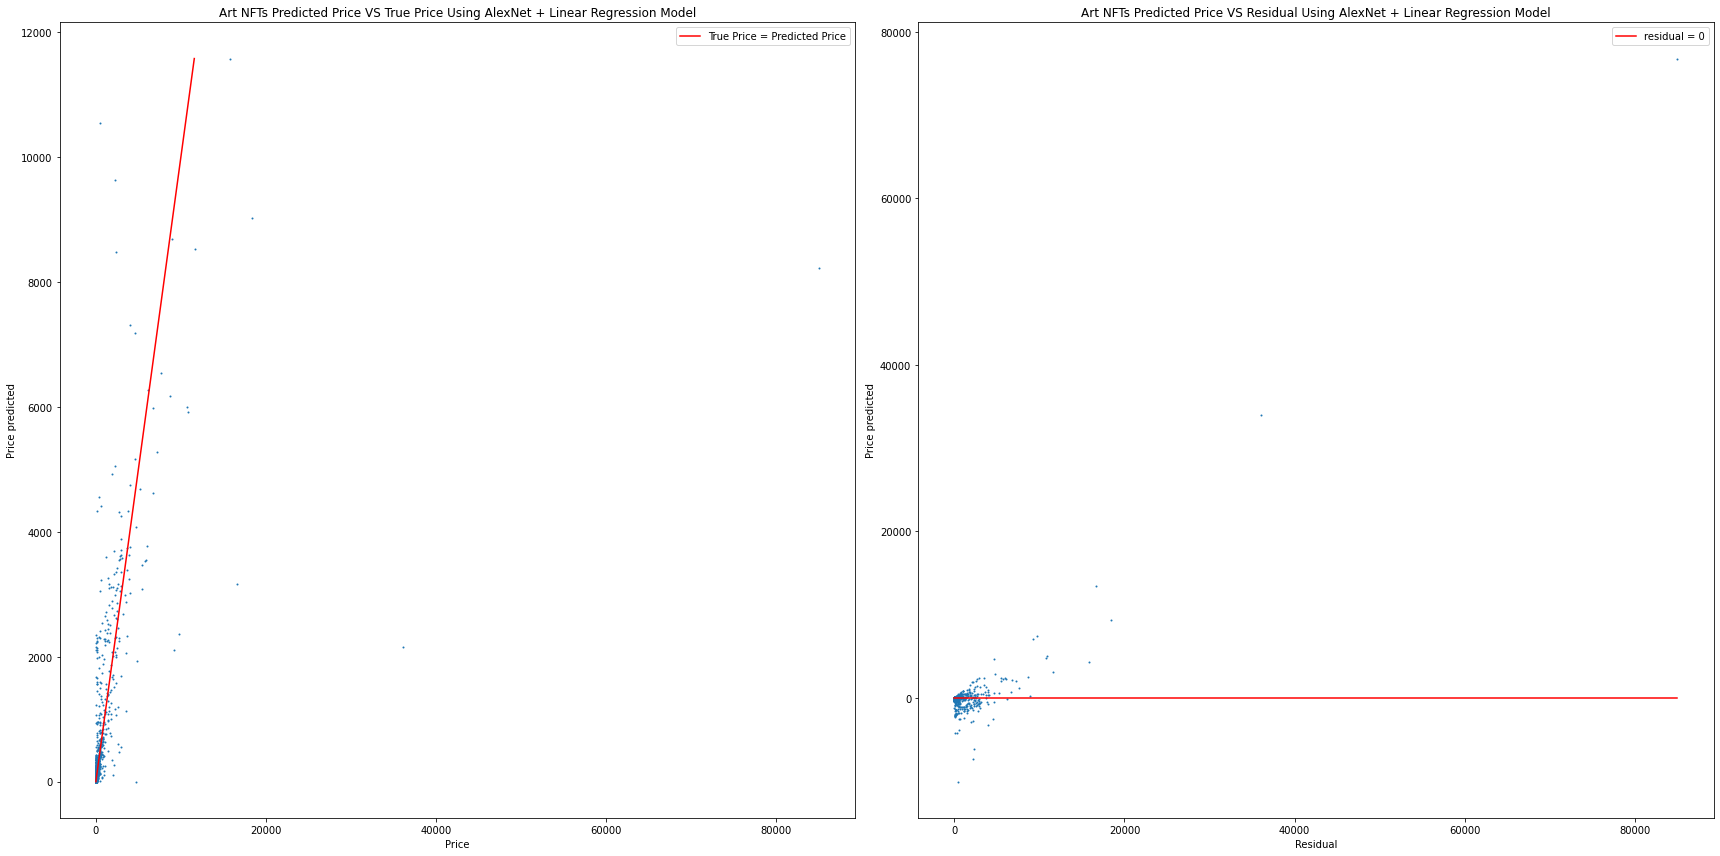

In [30]:
# 3.1 AlexNet + Linear Regression
def rmse(a, b):
    return float(np.sqrt(((a - b) ** 2).mean()))

def ReLU(x):
  return np.maximum(x, 0, x)

# Prepare Data
data = pd.read_csv('/content/drive/MyDrive/294/AlexNet Data.csv').dropna()
# data = data[(data['Price_USD'] >= np.percentile(data['Price_USD'], 1)) & (data['Price_USD'] <= np.percentile(data['Price_USD'], 99))]

X = data.drop(columns = ["Unique_id_collection", "Image_url_1", "Price_USD", "Image_path"])
y = data["Price_USD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# fit the linear model and make predictions
lr = lm.LinearRegression(fit_intercept = True, normalize = True)
lr.fit(X_train, y_train)

# ReLU after linear regression to ensure output greater than 0
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test) 
y_train_pred = ReLU(y_train_pred)
y_test_pred = ReLU(y_test_pred)

# compute RMSE on train and test sets
train_rmse_cpc = rmse(y_train_pred, y_train)
test_rmse_cpc = rmse(y_test_pred, y_test)
display(train_rmse_cpc, test_rmse_cpc)


# Visualize training outcome
plt.figure(figsize=(24,12))     

plt.subplot(121)               

x = np.linspace(np.min(y_test_pred), np.max(y_test_pred),10)
plt.scatter(x = y_test, y = y_test_pred, s = 1)
plt.plot(x, x, '-r', label = 'True Price = Predicted Price')
plt.xlabel("Price")
plt.ylabel("Price predicted")
plt.title('Art NFTs Predicted Price VS True Price Using AlexNet + Linear Regression Model')
plt.legend()

plt.subplot(122)     
x = np.linspace(np.min(y_test), np.max(y_test),10)
plt.scatter(x = y_test, y = y_test - y_test_pred, s = 1)
plt.plot(x, 0 * x, '-r', label = 'residual = 0')
plt.xlabel("Residual")
plt.ylabel("Price predicted")
plt.title("Art NFTs Predicted Price VS Residual Using AlexNet + Linear Regression Model")
plt.legend()

plt.tight_layout()  

689.3814322417326

1205.4634207866995

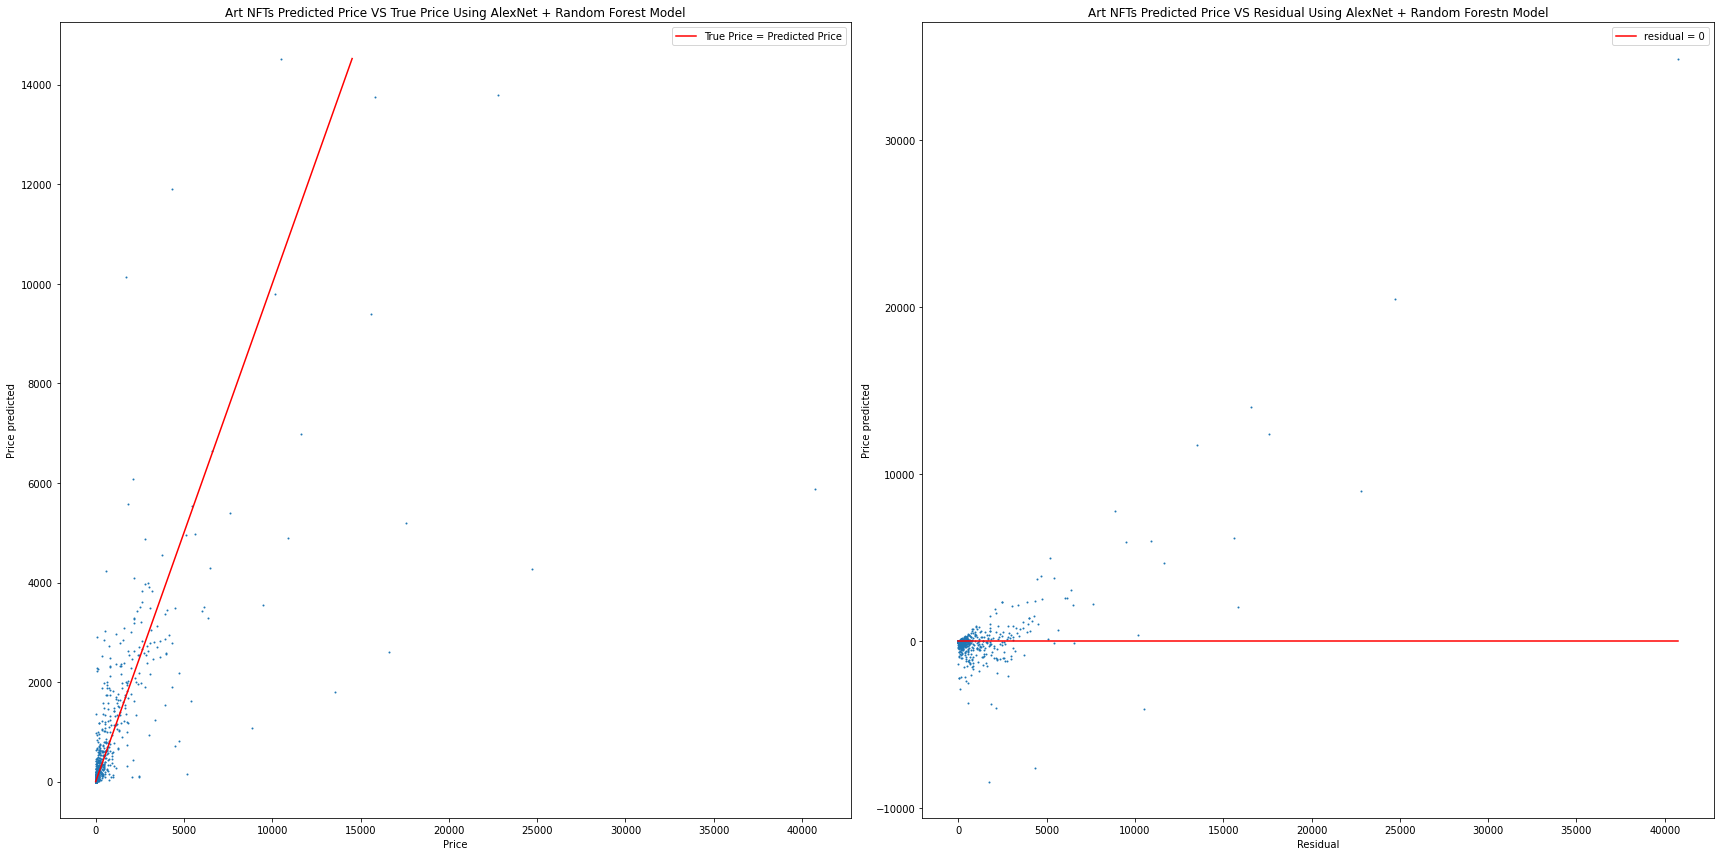

In [29]:
# 3.2 AlexNet + Random Forest
def rmse(a, b):
    return float(np.sqrt(((a - b) ** 2).mean()))

def ReLU(x):
  return np.maximum(x, 0, x)

# Prepare Data
data = pd.read_csv('/content/drive/MyDrive/294/AlexNet Data.csv').dropna()
# data = data[(data['Price_USD'] >= np.percentile(data['Price_USD'], 1)) & (data['Price_USD'] <= np.percentile(data['Price_USD'], 99))]

X = data.drop(columns = ["Unique_id_collection", "Image_url_1", "Price_USD", "Image_path"])
y = data["Price_USD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

 # create regressor object
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train, y_train)

# predict
y_test_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)
y_train_pred = ReLU(y_train_pred)
y_test_pred = ReLU(y_test_pred)

# compute RMSE on train and test sets
train_rmse_cpc = rmse(y_train_pred, y_train)
test_rmse_cpc = rmse(y_test_pred, y_test)
display(train_rmse_cpc, test_rmse_cpc)

# Visualize training outcome
plt.figure(figsize=(24,12))     

plt.subplot(121)               

x = np.linspace(np.min(y_test_pred), np.max(y_test_pred),10)
plt.scatter(x = y_test, y = y_test_pred, s = 1)
plt.plot(x, x, '-r', label = 'True Price = Predicted Price')
plt.xlabel("Price")
plt.ylabel("Price predicted")
plt.title('Art NFTs Predicted Price VS True Price Using AlexNet + Random Forest Model')
plt.legend()

plt.subplot(122)     
x = np.linspace(np.min(y_test), np.max(y_test),10)
plt.scatter(x = y_test, y = y_test - y_test_pred, s = 1)
plt.plot(x, 0 * x, '-r', label = 'residual = 0')
plt.xlabel("Residual")
plt.ylabel("Price predicted")
plt.title("Art NFTs Predicted Price VS Residual Using AlexNet + Random Forestn Model")
plt.legend()

plt.tight_layout()  